# GANs
---
## Dependencies

In [1]:
import helper
import os
import numpy as np
from glob import glob
from matplotlib import pyplot
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
import time
import numpy as np

%matplotlib inline

Found mnist Data
Found celeba Data


## Data

In [ ]:
data_dir = './data'

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

### MNIST

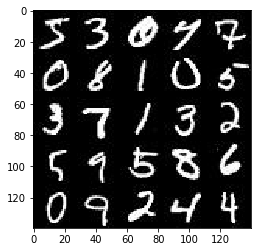

In [2]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA

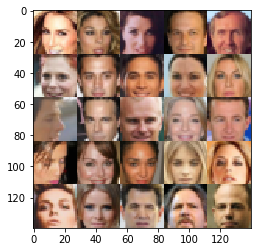

In [3]:
show_n_images = 25

celeb_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(celeb_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.12.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(dtype = tf.float32, shape = (None, image_width, image_height, image_channels))
    z_input = tf.placeholder(dtype = tf.float32, shape = (None, z_dim))
    learning_rate = tf.placeholder(dtype = tf.float32, shape = (None))
    
    return input_images, z_input, learning_rate

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.conv2d(inputs = images, filters = 64, kernel_size = 5, strides = 2, padding = 'same')
        h1 = tf.nn.leaky_relu(h1)
        
        h2 = tf.layers.conv2d(inputs = images, filters = 128, kernel_size = 5, strides = 2, padding = 'same')
        h2 = tf.layers.batch_normalization(h1, training = True)
        h2 = tf.nn.leaky_relu(h2)
        
        h3 = tf.layers.conv2d(inputs = images, filters = 256, kernel_size = 5, strides = 2, padding = 'same')
        h3 = tf.layers.batch_normalization(h3, training = True)
        h3 = tf.nn.leaky_relu(h3)
        
        flatten = tf.reshape(h3, (-1, h3.shape[1] * h3.shape[2] * h3.shape[3]))
        logits = tf.layers.dense(flatten, 1)
        out = tf.nn.sigmoid(logits)
        
    return logits, out

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train = True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        # Shape = (-1, 7, 7, 256)
        h1 = tf.layers.dense(z, 7 * 7 * 256)
        h1 = tf.reshape(h1, (-1, 7, 7, 64))
        h1 = tf.layers.batch_normalization(h1, training = is_train)
        h1 = tf.nn.leaky_relu(h1)
        
        # Shape = (-1, 14, 14, 128)
        h2 = tf.layers.conv2d_transpose(inputs = h1, filters = 128, kernel_size = 5, strides = (2, 2), padding = 'same')
        h2 = tf.layers.batch_normalization(h2, training = is_train)
        h2 = tf.nn.leaky_relu(h2)
        
        # Shape = (-1, 28, 28, out_channel_dim)
        logits = tf.layers.conv2d_transpose(inputs = h2, filters = out_channel_dim, kernel_size = 5, strides = (2, 2), padding = 'same')
        out = tf.nn.tanh(logits)

    return out

### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss

### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    d_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1).minimize(loss = d_loss, var_list = d_vars)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')):
        g_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1).minimize(loss = g_loss, var_list = g_vars)
    
    
    return d_opt, g_opt

## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode, model_name):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.draw()
    pyplot.savefig('imgs/' + model_name + str(time.time()) + '.png')

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, lr, beta1, get_batches, data_shape, data_image_mode, model_name):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Variables
    steps = 0
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    out_channel_dim = data_shape[-1]
    
    n_images_show = 4
    show_every_n_batches = 250
    print_every_n_batches = 10
    number_of_total_batches = (data_shape[0] // batch_size) * epoch_count
    
    # Running functions
    input_real, input_z, learning_rate = model_inputs(image_width, image_height, out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    train_threshold = 0.000005
    train_threshold_len = 20 #200 steps
    
    g_loss_hist = []
    d_loss_hist = []
    
    
    # Initialize tf graph session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer()) # initializes all variables 
        
        # Train for epoch_count number of epochs
        for epoch_i in range(epoch_count):
            # Trains on batches of images given batch_size
            for batch_images in get_batches(batch_size):
                # Increment step for showing samples every n batches
                steps += 1
                
                # Create input z
                batch_z = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                # Modify batch images which are normalized to -0.5 to 0.5 to work with tanh which is -1 to 1
                batch_images *= 2
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict = {input_real: batch_images, 
                                                 input_z: batch_z, 
                                                 learning_rate: lr})
                _ = sess.run(g_opt, feed_dict = {input_real: batch_images, 
                                                 input_z: batch_z, 
                                                 learning_rate: lr})
                
                # Outputs loss for every print_every_n_batches in steps
                if (steps % print_every_n_batches == 0):
                    # Saves value for losses of the discriminator and generator
                    train_loss_d = d_loss.eval({input_real: batch_images, 
                                                input_z: batch_z, 
                                                learning_rate: lr})
                    train_loss_g = g_loss.eval({input_real: batch_images, 
                                                input_z: batch_z, 
                                                learning_rate: lr})
                    
                    # Saves the loss of the networks to a list
                    d_loss_hist.append([steps, train_loss_d])
                    g_loss_hist.append([steps, train_loss_g])
                    
                    print("Epoch {} | Batch {}/{}".format(epoch_i, steps, number_of_total_batches),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}...".format(train_loss_g))
                
                Outputs generator images every show_every_n_batches batches
                if (steps % show_every_n_batches == 0):
                    show_generator_output(sess, n_images_show, input_z, out_channel_dim, data_image_mode, model_name)
                    
                #Terminates training if loss is not changing in a significant manner set by a threshold
                if (steps > train_threshold_len * print_every_n_batches and \
                    abs(train_loss_d - d_loss_hist[-train_threshold_len][1]) < train_threshold and \
                    abs(train_loss_g - g_loss_hist[-train_threshold_len][1]) < train_threshold and \
                    abs(train_loss_d - d_loss_hist[-train_threshold_len][1]) < train_threshold and \
                    abs(train_loss_g - g_loss_hist[-train_threshold_len][1]) < train_threshold):
                    print('...training ended early, no significant change in loss...')
                    
                    # Iterative training for epochs is done
                    print("...Done Training...")
    
                    # Converts the loss lists to numpy arrays
                    d_loss_hist = np.array(d_loss_hist)
                    g_loss_hist = np.array(g_loss_hist)
    
                    # returns the loss arrays
                    return d_loss_hist, g_loss_hist
    
    
    # Iterative training for epochs is done
    print("...Done Training...")
    
    # Converts the loss lists to numpy arrays
    d_loss_hist = np.array(d_loss_hist)
    g_loss_hist = np.array(g_loss_hist)
    
    # returns the loss arrays
    return d_loss_hist, g_loss_hist
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [12]:
m_name = 'mnist'
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    d_loss_hist_mnist, g_loss_hist_mnist = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, m_name)

Epoch 0 | Batch 10/3750 Discriminator Loss: 1.1542... Generator Loss: 0.6595...
Epoch 0 | Batch 20/3750 Discriminator Loss: 1.1809... Generator Loss: 0.6397...
Epoch 0 | Batch 30/3750 Discriminator Loss: 1.2589... Generator Loss: 0.6006...
Epoch 0 | Batch 40/3750 Discriminator Loss: 1.4607... Generator Loss: 0.4705...
Epoch 0 | Batch 50/3750 Discriminator Loss: 1.2858... Generator Loss: 0.6893...
Epoch 0 | Batch 60/3750 Discriminator Loss: 1.2410... Generator Loss: 0.6740...
Epoch 0 | Batch 70/3750 Discriminator Loss: 1.2427... Generator Loss: 0.6672...
Epoch 0 | Batch 80/3750 Discriminator Loss: 1.3464... Generator Loss: 0.6909...
Epoch 0 | Batch 90/3750 Discriminator Loss: 1.5068... Generator Loss: 0.4409...
Epoch 0 | Batch 100/3750 Discriminator Loss: 1.4256... Generator Loss: 0.4895...
Epoch 0 | Batch 110/3750 Discriminator Loss: 1.3903... Generator Loss: 0.5900...
Epoch 0 | Batch 120/3750 Discriminator Loss: 1.3859... Generator Loss: 0.6927...
Epoch 0 | Batch 130/3750 Discriminato

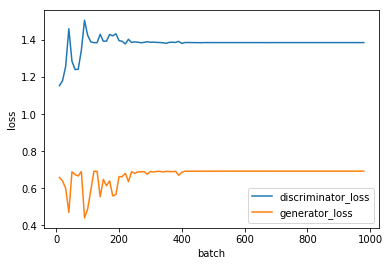

In [13]:
# Plotting the loss data
pyplot.plot(d_loss_hist_mnist[:,0], d_loss_hist_mnist[:,1])
pyplot.plot(g_loss_hist_mnist[:,0], g_loss_hist_mnist[:,1])
pyplot.legend(['discriminator_loss', 'generator_loss'])
pyplot.xlabel('batch')
pyplot.ylabel('loss')
pyplot.draw()
pyplot.savefig('imgs/figs/' + m_name + '_loss.png')

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [14]:
m_name = 'celeba'
batch_size = 32
z_dim = 128
learning_rate = 0.00002
beta1 = 0.25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    d_loss_hist_celeb, g_loss_hist_celeb = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, m_name)

Epoch 0 | Batch 10/6331 Discriminator Loss: 1.3537... Generator Loss: 0.5714...
Epoch 0 | Batch 20/6331 Discriminator Loss: 1.2522... Generator Loss: 0.6132...
Epoch 0 | Batch 30/6331 Discriminator Loss: 1.2451... Generator Loss: 0.6379...
Epoch 0 | Batch 40/6331 Discriminator Loss: 1.1945... Generator Loss: 0.6477...
Epoch 0 | Batch 50/6331 Discriminator Loss: 1.1886... Generator Loss: 0.6530...
Epoch 0 | Batch 60/6331 Discriminator Loss: 1.1769... Generator Loss: 0.6619...
Epoch 0 | Batch 70/6331 Discriminator Loss: 1.1674... Generator Loss: 0.6641...
Epoch 0 | Batch 80/6331 Discriminator Loss: 1.1537... Generator Loss: 0.6660...
Epoch 0 | Batch 90/6331 Discriminator Loss: 1.1609... Generator Loss: 0.6654...
Epoch 0 | Batch 100/6331 Discriminator Loss: 1.1821... Generator Loss: 0.6678...
Epoch 0 | Batch 110/6331 Discriminator Loss: 1.1699... Generator Loss: 0.6704...
Epoch 0 | Batch 120/6331 Discriminator Loss: 1.1561... Generator Loss: 0.6706...
Epoch 0 | Batch 130/6331 Discriminato

Epoch 0 | Batch 2010/6331 Discriminator Loss: 1.2432... Generator Loss: 0.6530...
Epoch 0 | Batch 2020/6331 Discriminator Loss: 1.2780... Generator Loss: 0.6214...
Epoch 0 | Batch 2030/6331 Discriminator Loss: 1.2731... Generator Loss: 0.6316...
Epoch 0 | Batch 2040/6331 Discriminator Loss: 1.2654... Generator Loss: 0.6304...
Epoch 0 | Batch 2050/6331 Discriminator Loss: 1.2717... Generator Loss: 0.6470...
Epoch 0 | Batch 2060/6331 Discriminator Loss: 1.2584... Generator Loss: 0.6337...
Epoch 0 | Batch 2070/6331 Discriminator Loss: 1.3201... Generator Loss: 0.6305...
Epoch 0 | Batch 2080/6331 Discriminator Loss: 1.3262... Generator Loss: 0.6235...
Epoch 0 | Batch 2090/6331 Discriminator Loss: 1.3152... Generator Loss: 0.6346...
Epoch 0 | Batch 2100/6331 Discriminator Loss: 1.3065... Generator Loss: 0.6212...
Epoch 0 | Batch 2110/6331 Discriminator Loss: 1.2974... Generator Loss: 0.6317...
Epoch 0 | Batch 2120/6331 Discriminator Loss: 1.2964... Generator Loss: 0.6264...
Epoch 0 | Batch 

Epoch 0 | Batch 3990/6331 Discriminator Loss: 1.3864... Generator Loss: 0.6930...
Epoch 0 | Batch 4000/6331 Discriminator Loss: 1.3864... Generator Loss: 0.6930...
...training ended early, no significant change in loss...
...Done Training...


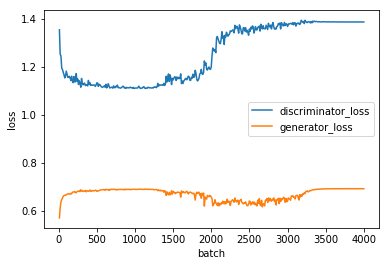

In [16]:
# Plotting the loss data
pyplot.plot(d_loss_hist_celeb[:,0], d_loss_hist_celeb[:,1])
pyplot.plot(g_loss_hist_celeb[:,0], g_loss_hist_celeb[:,1])
pyplot.legend(['discriminator_loss', 'generator_loss'])
pyplot.xlabel('batch')
pyplot.ylabel('loss')
pyplot.draw()
pyplot.savefig('imgs/figs/' + m_name + '_loss.png')

In [ ]:
# end of code